# Importación de librerías y carga de datos

In [111]:
"""
Modulo de entrenamiento para diferentes pipelines de ML para el
entrenamiento utilizando los datasets creados. El flujo es capaz de 
generalizar en la mayoría de los casos y únicamente es necesario
realizar modificaciones en la ruta a los datos.
"""
import os
import pandas as pd 
import seaborn as sns                                                   
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, \
                                    cross_val_score, \
                                    learning_curve, \
                                    RandomizedSearchCV, \
                                    GridSearchCV
from sklearn.inspection import permutation_importance
import numpy as np
from sklearn.svm import SVC
from sklearn import datasets, metrics
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from boruta import BorutaPy
from tpot import TPOTClassifier
import dataframe_image as dfi
from keras.models import Sequential,load_model,model_from_json
import itertools
import joblib  
from sklearn.metrics import confusion_matrix, recall_score, precision_score


path_santiago = r'C:\Users\santi\Universidad de Antioquia\VALERIA CADAVID CASTRO - Resultados_Armonizacion_BD'
path_veronica = r'C:\Users\veroh\OneDrive - Universidad de Antioquia\Verónica Henao Isaza\Resultados\dataframes'
path_save =r'C:\Users\veroh\OneDrive - Universidad de Antioquia\Verónica Henao Isaza\Resultados'
neuro = 'sovaHarmony'
name = 'G1'
space = 'ic'
var = ''
path_plot = path_save +rf'\graphics\ML/{neuro}/{name}_{var}_{space}'
os.makedirs(path_plot,exist_ok=True)

path = path_veronica
path_df = rf'{path}\{neuro}\integration\{space}\{name}\Data_complete_{space}_{neuro}_{name}.feather'

path_excel = path_save + rf'\tables\ML\{space}\{name}'
os.makedirs(path_excel,exist_ok=True)

path_excel1 = path_excel + rf'\describe_all_{var}.xlsx'
path_excel2 = path_excel + rf'\describe_{var}.xlsx'
path_excel3 = path_excel + rf'\features_{var}.xlsx'

In [2]:
# compute precision and recall
def computerprecision(test_label,classes_x):
  precision_test = precision_score(test_label,classes_x)
  recall_test = recall_score(test_label, classes_x)
  f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
  print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

In [3]:
def plot_confusion_matrix(path_plot,cm, classes,normalize=False,title='Confusion matrix',cmap='coolwarm'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path_plot+'/'+'confusion_matrix.png')

In [4]:
modelos = {}
acc_per_feature = []
std_per_feature = []

In [5]:
data = pd.read_feather(path_df)

In [6]:
data

,power_C14_Delta,power_C14_Theta,power_C14_Alpha-1,power_C14_Alpha-2,power_C14_Beta1,power_C14_Beta2,power_C14_Beta3,power_C14_Gamma,power_C15_Delta,power_C15_Theta,...,crossfreq_C24_Mbeta3_Gamma,crossfreq_C24_Mgamma_Gamma,crossfreq_C25_Mdelta_Gamma,crossfreq_C25_Mtheta_Gamma,crossfreq_C25_Malpha-1_Gamma,crossfreq_C25_Malpha-2_Gamma,crossfreq_C25_Mbeta1_Gamma,crossfreq_C25_Mbeta2_Gamma,crossfreq_C25_Mbeta3_Gamma,crossfreq_C25_Mgamma_Gamma
0,0.118310,0.046252,0.053277,0.062740,0.210937,0.114947,0.202591,0.190946,0.360310,0.076946,...,0.362133,2.409412,0.120109,0.016069,0.023164,0.035333,0.083127,0.022919,0.112423,0.614388
1,0.222268,0.082103,0.133289,0.084380,0.140297,0.077445,0.150640,0.109576,0.318443,0.107238,...,0.156967,0.687043,0.138475,0.031554,0.180072,0.131449,0.102960,0.019746,0.064726,0.181609
2,0.226389,0.080803,0.056726,0.059182,0.148314,0.047616,0.167221,0.213748,0.437308,0.136294,...,0.283155,1.276087,0.074551,0.015315,0.020458,0.037985,0.067400,0.016127,0.131574,0.380644
3,0.060198,0.054098,0.104426,0.110820,0.207209,0.071979,0.269997,0.121274,0.126824,0.123962,...,0.125365,0.461543,0.083464,0.029778,0.067441,0.090753,0.086718,0.018876,0.108672,0.283570
4,0.140012,0.073167,0.059593,0.065545,0.186926,0.080051,0.212356,0.182350,0.247711,0.122759,...,0.070535,0.201157,0.080195,0.039754,0.053179,0.070659,0.067023,0.013998,0.064952,0.166767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,0.167348,0.096056,0.170960,0.074744,0.119454,0.035066,0.321038,0.015334,0.233710,0.107456,...,0.027948,0.030058,0.088419,0.161301,0.315845,0.171319,0.048606,0.009626,0.132796,0.092126
143,0.226428,0.079622,0.169942,0.170373,0.191978,0.057792,0.093062,0.010804,0.263743,0.088319,...,0.018482,0.016458,0.095153,0.065397,0.150760,0.117757,0.078759,0.013690,0.023695,0.026579
144,0.117354,0.077017,0.553260,0.115741,0.055296,0.032301,0.038667,0.010363,0.087728,0.063041,...,0.043029,0.054872,0.079511,0.116307,0.252091,0.189823,0.072308,0.016260,0.057955,0.054562
145,0.257382,0.072319,0.162746,0.282953,0.124002,0.023593,0.048525,0.028480,0.481628,0.137638,...,0.037085,0.049992,0.128109,0.050709,0.164024,0.275433,0.171037,0.014025,0.041827,0.043977


In [7]:
print(f'sujetos: {data.shape[0]} | caracteristicas: {data.shape[1]}')

sujetos: 147 | caracteristicas: 557


# Preprocesamiento

## Análisis exploratorio de datos

In [8]:
for group in data['group'].unique():
        
        print('{} : {}'.format(group, (data['group']==group).sum()))

G1 : 49
Control : 98


In [9]:
data.describe().T.to_excel(path_excel1)

In [10]:
data.groupby(by='group').describe().T.to_excel(path_excel2)

In [11]:
def delcol(data,m,b,roi,bm=None):
    for metrici in m:
        for bandi in b:
            for ri in roi:
                if metrici != 'crossfreq':
                    data.drop([metrici+'_'+ri+'_'+bandi],axis=1,inplace=True)
                else:
                    for modul in bm:
                        if modul == 'MGAMMA':
                            modul = modul[0]+modul[1:].swapcase()
                        else:
                            pass
                        try:
                            data.drop([metrici+'_'+ri+'_'+modul+'_'+bandi],axis=1,inplace=True)
                        except:
                            continue
    return data

In [12]:
m = ['power','sl','cohfreq','entropy','crossfreq']
bm = ['Mdelta','Mtheta','Malpha-1','Malpha-2','Mbeta1','Mbeta2','Mbeta3','Mgamma']
if space == 'roi':
    roi = ['F','C','T','PO']
elif space == 'ic':
    roi = ['C14','C15','C18','C20','C22','C23','C24','C25'] #ic
#data = delcol(data,m,['Gamma'],roi,bm)

In [ ]:
col_del = pd.DataFrame()

In [13]:
# eliminación de columnas con datos faltantes

for column in data.columns:

    if data[column].isna().sum() != 0:
        col_del[column] = [data[column].isna().sum()]

        print('{} : {}'.format(column, (data[column].isna().sum())))
        data.drop(column, axis=1, inplace=True)

MM_total : 41
FAS_F : 78
FAS_S : 78
FAS_A : 78
education : 41


In [ ]:
dfi.export(col_del, path_plot+'/coldel.png')

In [14]:
data

,power_C14_Delta,power_C14_Theta,power_C14_Alpha-1,power_C14_Alpha-2,power_C14_Beta1,power_C14_Beta2,power_C14_Beta3,power_C14_Gamma,power_C15_Delta,power_C15_Theta,...,crossfreq_C24_Mbeta3_Gamma,crossfreq_C24_Mgamma_Gamma,crossfreq_C25_Mdelta_Gamma,crossfreq_C25_Mtheta_Gamma,crossfreq_C25_Malpha-1_Gamma,crossfreq_C25_Malpha-2_Gamma,crossfreq_C25_Mbeta1_Gamma,crossfreq_C25_Mbeta2_Gamma,crossfreq_C25_Mbeta3_Gamma,crossfreq_C25_Mgamma_Gamma
0,0.118310,0.046252,0.053277,0.062740,0.210937,0.114947,0.202591,0.190946,0.360310,0.076946,...,0.362133,2.409412,0.120109,0.016069,0.023164,0.035333,0.083127,0.022919,0.112423,0.614388
1,0.222268,0.082103,0.133289,0.084380,0.140297,0.077445,0.150640,0.109576,0.318443,0.107238,...,0.156967,0.687043,0.138475,0.031554,0.180072,0.131449,0.102960,0.019746,0.064726,0.181609
2,0.226389,0.080803,0.056726,0.059182,0.148314,0.047616,0.167221,0.213748,0.437308,0.136294,...,0.283155,1.276087,0.074551,0.015315,0.020458,0.037985,0.067400,0.016127,0.131574,0.380644
3,0.060198,0.054098,0.104426,0.110820,0.207209,0.071979,0.269997,0.121274,0.126824,0.123962,...,0.125365,0.461543,0.083464,0.029778,0.067441,0.090753,0.086718,0.018876,0.108672,0.283570
4,0.140012,0.073167,0.059593,0.065545,0.186926,0.080051,0.212356,0.182350,0.247711,0.122759,...,0.070535,0.201157,0.080195,0.039754,0.053179,0.070659,0.067023,0.013998,0.064952,0.166767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,0.167348,0.096056,0.170960,0.074744,0.119454,0.035066,0.321038,0.015334,0.233710,0.107456,...,0.027948,0.030058,0.088419,0.161301,0.315845,0.171319,0.048606,0.009626,0.132796,0.092126
143,0.226428,0.079622,0.169942,0.170373,0.191978,0.057792,0.093062,0.010804,0.263743,0.088319,...,0.018482,0.016458,0.095153,0.065397,0.150760,0.117757,0.078759,0.013690,0.023695,0.026579
144,0.117354,0.077017,0.553260,0.115741,0.055296,0.032301,0.038667,0.010363,0.087728,0.063041,...,0.043029,0.054872,0.079511,0.116307,0.252091,0.189823,0.072308,0.016260,0.057955,0.054562
145,0.257382,0.072319,0.162746,0.282953,0.124002,0.023593,0.048525,0.028480,0.481628,0.137638,...,0.037085,0.049992,0.128109,0.050709,0.164024,0.275433,0.171037,0.014025,0.041827,0.043977


In [15]:
print(f'sujetos: {data.shape[0]} | caracteristicas: {data.shape[1]}')

sujetos: 147 | caracteristicas: 552


In [16]:
# Se mapean las clases 

clases_mapeadas = {label:idx for idx,label  
                   in enumerate(np.unique(data['group']))}

data.loc[:,'group'] = data.loc[:,'group'].map(clases_mapeadas) 
print(clases_mapeadas)

{'Control': 0, 'G1': 1}


C:\Users\veroh\AppData\Local\Temp\ipykernel_12136\383920285.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'group'] = data.loc[:,'group'].map(clases_mapeadas)


In [17]:
print(data.dtypes.unique())

[dtype('float64') dtype('O') dtype('int64')]


In [18]:
data.select_dtypes('O')

,database,participant_id,visit,condition,sex
0,BIOMARCADORES,sub-G1024,V0,CE,M
1,BIOMARCADORES,sub-G1023,V0,CE,F
2,BIOMARCADORES,sub-G1022,V0,CE,F
3,BIOMARCADORES,sub-G1021,V0,CE,F
4,BIOMARCADORES,sub-G1019,V0,CE,F
...,...,...,...,...,...
142,CHBMP,sub-CBM00167,V0,protmap,M
143,CHBMP,sub-CBM00156,V0,protmap,F
144,CHBMP,sub-CBM00147,V0,protmap,F
145,CHBMP,sub-CBM00283,V0,protmap,F


In [19]:
data.groupby(by='sex').describe().T

sex                                       F          M
power_C14_Delta            count  79.000000  68.000000
                           mean    0.189329   0.202634
                           std     0.098491   0.116002
                           min     0.036526   0.014105
                           25%     0.117292   0.120809
...                                     ...        ...
crossfreq_C25_Mgamma_Gamma min     0.017936   0.016030
                           25%     0.090535   0.047468
                           50%     0.148857   0.089681
                           75%     0.290599   0.205081
                           max     1.496271   1.760359

[4376 rows x 2 columns]

In [20]:
sexo_mapeado = {label:idx for idx,label
                in enumerate(np.unique(data['sex']))}

data.loc[:,'sex'] = data.loc[:,'sex'].map(sexo_mapeado) 
print(sexo_mapeado)

{'F': 0, 'M': 1}


C:\Users\veroh\AppData\Local\Temp\ipykernel_12136\2216644689.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'sex'] = data.loc[:,'sex'].map(sexo_mapeado)


In [21]:
# data pasa a ser el arreglo únicamente con los datos númericos

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

data = data.select_dtypes(include=numerics)

data.shape

(147, 548)

In [22]:
# Se elimina la columna, para ponerla al final

target = data.pop('group')
data.insert(len(data.columns), target.name, target)

## Selección de caracteristicas

### Creación de datasets de entrenamiento y test

In [23]:
X = data.values[:,:-1]
y = data.values[:,-1]
print(X.shape)
print(y.shape)

(147, 547)
(147,)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(                            
    X, # Valores de X
    y, # Valores de Y
    test_size=0.2, # Test de 20%
    random_state=1, # Semilla
    stratify=data.values[:,-1]) # que se mantenga la proporcion en la división

### Mapa de calor de correlación

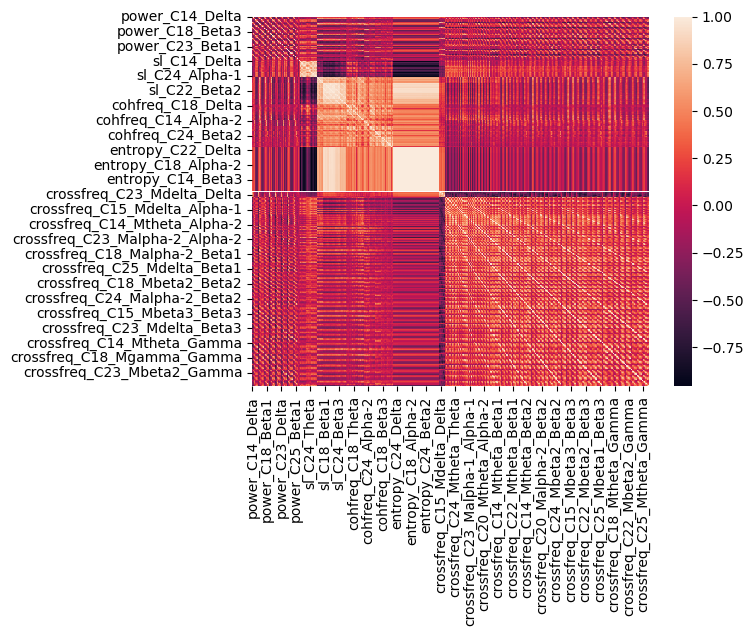

In [25]:
sns.heatmap(data.corr())
plt.title('Correlation matrix for all features')
plt.xlabel('Features')
plt.ylable('Features')
plt.savefig(path_plot+'/'+'correlation_all.png')

### Árboles de decisión (Grid Search)

In [26]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 30)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
criterion = ['gini',  'entropy', 'log_loss']

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion
               }

In [27]:
forestclf_grid = RandomForestClassifier()

rf_random = RandomizedSearchCV(
                              estimator=forestclf_grid,
                              param_distributions=random_grid,
                              n_iter=100,
                              cv=10,
                              verbose=2,
                              random_state=10,
                              n_jobs=-1
                              )

rf_random.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 165, 231, 296,
                                                         362, 427, 493, 558,
                                                         624, 689, 755, 820,
                                                         886, 951, 1017, 1082,
                                                         1148, 1213, 1279, 1344,
                                                         1410, 1475, 1541, 1606,
                                                         1672, 1737, 1803, 1868,
                                                         1934, 2000]},
                   random_state=10, verbose=2)

In [28]:
best_selected = rf_random.best_estimator_

In [29]:
best_selected

RandomForestClassifier(criterion='log_loss', max_depth=90, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=296)

In [30]:
GS_fitted = best_selected.fit(X_train, y_train)
modelos['GridSerach'] = GS_fitted

In [31]:
predicted = GS_fitted.predict(X_test)

In [32]:
print(
    f"Classification report for classifier {GS_fitted}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
    )

Classification report for classifier RandomForestClassifier(criterion='log_loss', max_depth=90, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=296):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30




In [33]:
dataframe_metrics = metrics.classification_report(y_test, predicted, output_dict=True)
dataframe_metrics = pd.DataFrame(dataframe_metrics).T
dfi.export(dataframe_metrics, path_plot+'/'+'metrics'+'_Grid Search_.png')

C:\Program Files\Google\Chrome\Application\chrome.exe


In [34]:
scores = cross_val_score(
                        estimator=GS_fitted,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=-1
                        )

In [35]:
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [1.         1.         1.         1.         1.         0.91666667
 1.         0.81818182 1.         1.        ]


In [36]:
print('\nCV accuracy: %.3f +/- %.3f' %
    (np.mean(scores), np.std(scores)))

acc_per_feature.append(np.mean(scores))
std_per_feature.append(np.std(scores))


CV accuracy: 0.973 +/- 0.057


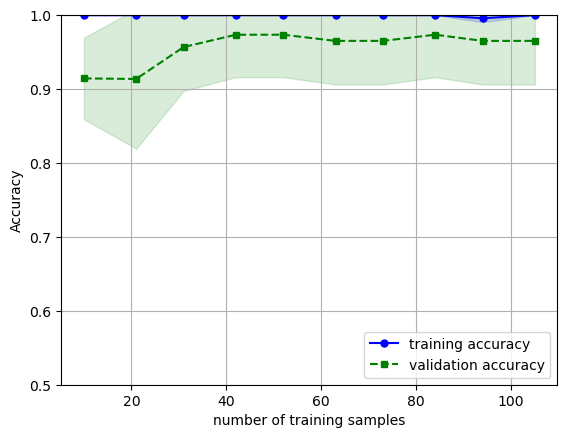

In [37]:
train_sizes, train_scores, test_scores = \
    learning_curve(
                  estimator=GS_fitted,
                  X=X_train,
                  y=y_train,
                  train_sizes=np.linspace(0.1, 1, 10),
                  cv=10,
                  n_jobs=-1
                  )
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(
        train_sizes,
        train_mean,
        color='blue',
        marker='o',
        markersize=5,
        label='training accuracy'
        )

plt.fill_between(
                train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15,
                color='blue'
                )

plt.plot(
        train_sizes,
        test_mean,
        color='green',
        linestyle='--',
        marker='s',
        markersize=5,
        label='validation accuracy'
        )

plt.fill_between(
                train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15,
                color='green'
                )

plt.grid()
plt.title('Validation curve for Grid Search')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.0])

plt.savefig(path_plot+'/'+'validation_GridSearch.png')
plt.show()

### Árboles de decisión (Boruta)

In [38]:
feat_selector = BorutaPy(
                        verbose=2,
                        estimator=best_selected,
                        max_iter=100,
                        random_state=10
                        )

In [39]:
feat_selector.fit(X_train, y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	135
Tentative: 	114
Rejected: 	298
Iteration: 	9 / 100
Confirmed: 	135
Tentative: 	114
Rejected: 	298
Iteration: 	10 / 100
Confirmed: 	135
Tentative: 	114
Rejected: 	298
Iteration: 	11 / 100
Confirmed: 	135
Tentative: 	114
Rejected: 	298
Iteration: 	12 / 100
Confirmed: 	138
Tentative: 	92
Rejected: 	317
Iteration: 	13 / 100
Confirmed: 	138
Tentative: 	92
Rejected: 	317
Iteration: 	14 / 100
Confirmed: 	138
Tentative: 	92
Rejected: 	317
Iteration: 	15 / 100
Confirmed: 	138
Tentative: 	92
Rejected: 	317
Iteration: 	16 / 100


BorutaPy(estimator=RandomForestClassifier(criterion='log_loss', max_depth=90,
                                          min_samples_leaf=2,
                                          min_samples_split=5,
                                          n_estimators=1000,
                                          random_state=RandomState(MT19937) at 0x236FCFAC340),
         random_state=RandomState(MT19937) at 0x236FCFAC340, verbose=2)

In [40]:
selected_features = []
print("\n------Support and Ranking for each feature------")
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        print("Passes the test: ", data.columns[i],
              " - Ranking: ", feat_selector.ranking_[i])
        selected_features.append(data.columns[i])


------Support and Ranking for each feature------
Passes the test:  power_C14_Delta  - Ranking:  1
Passes the test:  power_C14_Beta3  - Ranking:  1
Passes the test:  power_C18_Beta2  - Ranking:  1
Passes the test:  power_C20_Beta1  - Ranking:  1
Passes the test:  power_C22_Delta  - Ranking:  1
Passes the test:  power_C23_Beta1  - Ranking:  1
Passes the test:  power_C24_Delta  - Ranking:  1
Passes the test:  sl_C14_Theta  - Ranking:  1
Passes the test:  sl_C15_Theta  - Ranking:  1
Passes the test:  sl_C22_Theta  - Ranking:  1
Passes the test:  sl_C14_Alpha-1  - Ranking:  1
Passes the test:  sl_C15_Alpha-1  - Ranking:  1
Passes the test:  sl_C18_Alpha-1  - Ranking:  1
Passes the test:  sl_C20_Alpha-1  - Ranking:  1
Passes the test:  sl_C22_Alpha-1  - Ranking:  1
Passes the test:  sl_C23_Alpha-1  - Ranking:  1
Passes the test:  sl_C14_Alpha-2  - Ranking:  1
Passes the test:  sl_C15_Alpha-2  - Ranking:  1
Passes the test:  sl_C18_Alpha-2  - Ranking:  1
Passes the test:  sl_C20_Alpha-2  - R

In [41]:
X_transform = feat_selector.transform(X_train)

In [42]:
boruta_fitted = best_selected.fit(X_transform, y_train)
modelos['Boruta'] = boruta_fitted

In [43]:
selected_features = [data.columns.get_loc(c) for c in selected_features if c in data]
selected_features

[0,
 6,
 21,
 28,
 32,
 44,
 48,
 74,
 75,
 78,
 82,
 83,
 84,
 85,
 86,
 87,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 100,
 102,
 103,
 105,
 109,
 113,
 119,
 134,
 137,
 143,
 145,
 167,
 168,
 169,
 175,
 176,
 177,
 182,
 183,
 184,
 185,
 188,
 190,
 191,
 192,
 193,
 202,
 203,
 207,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 263,
 265,
 343,
 363,
 373,
 383,
 384,
 396,
 401,
 402,
 407,
 408,
 419,
 420,
 426,
 431,
 432,
 433,
 446,
 447,
 452,
 453,
 454,
 459,
 460,
 461,
 473,
 474,
 475,
 487,
 488,
 489,
 490,
 498,
 505,
 506,
 512,
 513,
 514,
 519,
 520,
 521,
 522,
 530,
 536,
 537,
 538,
 546]

In [44]:
predicted = boruta_fitted.predict(X_test[:,selected_features])

In [45]:
print(
    f"Classification report for classifier {boruta_fitted}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

Classification report for classifier RandomForestClassifier(criterion='log_loss', max_depth=90, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=1000,
                       random_state=RandomState(MT19937) at 0x236FCFAC340):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30




In [46]:
dataframe_metrics = metrics.classification_report(y_test, predicted, output_dict=True)
dataframe_metrics = pd.DataFrame(dataframe_metrics).T
dfi.export(dataframe_metrics, path_plot+'/'+'metrics_boruta.png')

C:\Program Files\Google\Chrome\Application\chrome.exe


In [47]:
scores = cross_val_score(estimator=boruta_fitted,
                        X=X_transform,
                        y=y_train,
                        cv=10,
                        n_jobs=-1)

In [48]:
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [0.91666667 1.         1.         1.         1.         0.91666667
 1.         0.81818182 1.         1.        ]


In [49]:
print('\nCV accuracy: %.3f +/- %.3f' %
    (np.mean(scores), np.std(scores)))


acc_per_feature.append(np.mean(scores))
std_per_feature.append(np.std(scores))


CV accuracy: 0.965 +/- 0.059


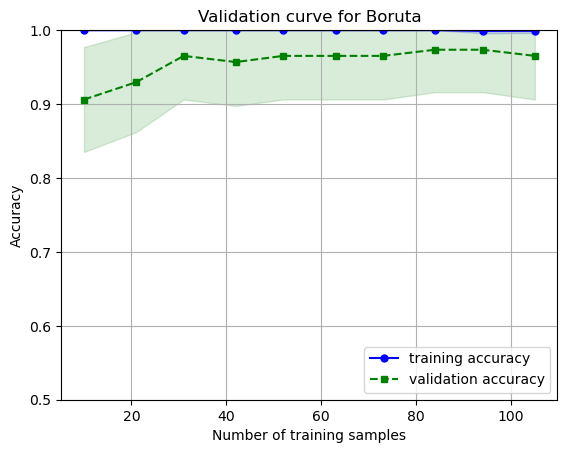

In [101]:
train_sizes, train_scores, test_scores = \
    learning_curve(
                  estimator=boruta_fitted,
                  X=X_transform,
                  y=y_train,
                  train_sizes=np.linspace(0.1, 1, 10),
                  cv=10,
                  n_jobs=-1
                  )
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(
        train_sizes,
        train_mean,
        color='blue',
        marker='o',
        markersize=5,
        label='training accuracy'
        )

plt.fill_between(
                train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15,
                color='blue'
                )

plt.plot(
        train_sizes,
        test_mean,
        color='green',
        linestyle='--',
        marker='s',
        markersize=5,
        label='validation accuracy'
        )

plt.fill_between(
                train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15,
                color='green'
                )

plt.grid()
plt.title('Validation curve for Boruta')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.0])
plt.savefig(path_plot+'/'+'validation_Boruta.png')
plt.show()

### Selección de caracteristicas con árboles de decisión

In [109]:
feat = pd.DataFrame()

 1) crossfreq_C14_Mbeta3_Gamma     0.029965
 2) crossfreq_C14_Mbeta3_Beta3     0.028414
 3) crossfreq_C14_Mgamma_Gamma     0.024440
 4) sl_C14_Alpha-1                 0.023038
 5) crossfreq_C22_Mbeta2_Beta2     0.019903
 6) crossfreq_C22_Mbeta3_Beta3     0.019035
 7) crossfreq_C22_Mbeta2_Gamma     0.018699
 8) crossfreq_C22_Mbeta2_Beta3     0.017802
 9) crossfreq_C14_Mbeta2_Gamma     0.014712
10) crossfreq_C24_Mbeta3_Beta3     0.012864
11) sl_C15_Alpha-1                 0.012514
12) crossfreq_C22_Mbeta3_Gamma     0.012465
13) crossfreq_C22_Mbeta1_Beta1     0.012054
14) cohfreq_C23_Beta3              0.011838
15) crossfreq_C24_Mbeta3_Gamma     0.011660
16) sl_C14_Theta                   0.010933
17) crossfreq_C20_Mgamma_Gamma     0.010770
18) crossfreq_C22_Mgamma_Gamma     0.010736
19) crossfreq_C14_Mbeta2_Beta2     0.010446
20) sl_C25_Alpha-2                 0.010440
21) cohfreq_C23_Beta2              0.010270
22) sl_C20_Alpha-1                 0.010136
23) sl_C22_Alpha-1              

C:\Users\veroh\AppData\Local\Temp\ipykernel_12136\2434835606.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feat[nombres_columnas[index[f]]] = [features_scores[index[f]]]
C:\Users\veroh\AppData\Local\Temp\ipykernel_12136\2434835606.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feat[nombres_columnas[index[f]]] = [features_scores[index[f]]]
C:\Users\veroh\AppData\Local\Temp\ipykernel_12136\2434835606.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

384) crossfreq_C25_Malpha-2_Gamma   0.000195
385) crossfreq_C22_Malpha-1_Alpha-2 0.000195
386) crossfreq_C25_Malpha-1_Beta3   0.000194
387) crossfreq_C22_Mtheta_Theta     0.000193
388) power_C15_Beta2                0.000193
389) crossfreq_C15_Mtheta_Alpha-1   0.000190
390) crossfreq_C18_Malpha-1_Alpha-1 0.000190
391) crossfreq_C15_Malpha-1_Gamma   0.000185
392) crossfreq_C18_Malpha-1_Beta1   0.000183
393) crossfreq_C18_Mtheta_Theta     0.000182
394) cohfreq_C15_Beta2              0.000181
395) sl_C18_Gamma                   0.000179
396) crossfreq_C23_Mdelta_Beta2     0.000178
397) crossfreq_C23_Mdelta_Beta3     0.000178
398) crossfreq_C14_Mdelta_Beta1     0.000175
399) crossfreq_C22_Malpha-1_Alpha-1 0.000173
400) power_C22_Alpha-2              0.000172
401) cohfreq_C14_Delta              0.000172
402) crossfreq_C23_Mdelta_Theta     0.000171
403) crossfreq_C25_Malpha-1_Alpha-2 0.000169
404) crossfreq_C22_Malpha-2_Gamma   0.000168
405) crossfreq_C23_Mtheta_Gamma     0.000166
406) cross

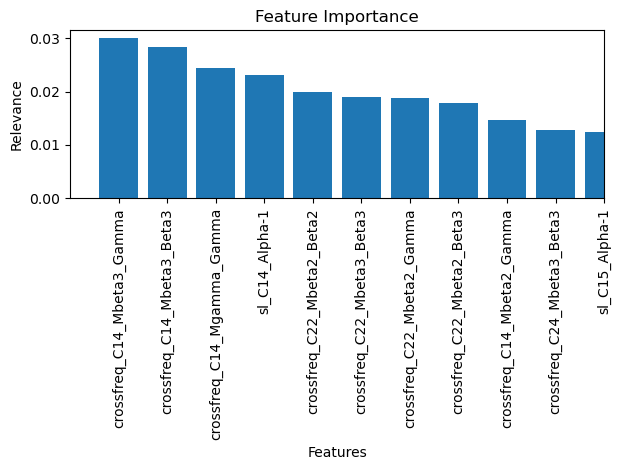

In [110]:
nombres_columnas = data.columns[:-1]
best_selected.fit(X_train, y_train)
features_scores = best_selected.feature_importances_
features_scores
index = np.argsort(features_scores)[::-1]
sorted_names = []

for f in range(X_train.shape[1]):

    sorted_names.append(nombres_columnas[index[f]])
    print("%2d) %-*s %f" % (f + 1, 30,
                        nombres_columnas[index[f]],
                        features_scores[index[f]]))
    feat[nombres_columnas[index[f]]] = [features_scores[index[f]]]
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Relevance')

plt.bar(range(X_train.shape[1]),
    features_scores[index],
    align='center')

plt.xticks(range(X_train.shape[1]),
    nombres_columnas[index],
    rotation=90)

plt.xlim([-1, 10])

plt.tight_layout()
plt.savefig(path_plot+'/'+'feature_importance.png')

plt.show()

In [112]:
feat.describe().T.to_excel(path_excel3)

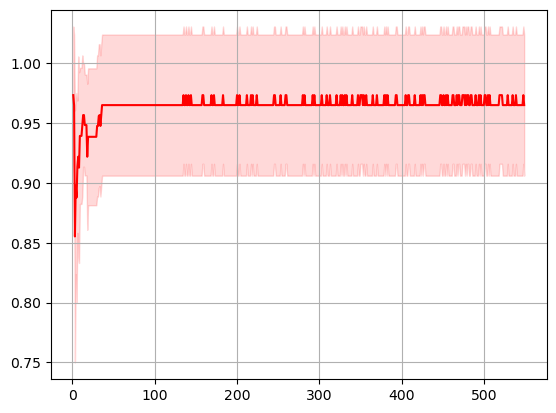

In [52]:
for index, feature_name in enumerate(sorted_names,start=1):

    input_features_names = sorted_names[:index]
    input_features_index = [data.columns.get_loc(c) for c 
                      in input_features_names if c in data]
    feature_model = best_selected.fit(X_train[:, input_features_index], y_train)
    scores = cross_val_score(
                        estimator=feature_model,
                        X=X_train[:, input_features_index],
                        y=y_train,
                        cv=10,
                        n_jobs=-1
                        )
    
  
    modelos['number_features_' + str(index)] = feature_model
    acc_per_feature.append(np.mean(scores))
    std_per_feature.append(np.std(scores))


#plt.plot(
#        range(1, len(sorted_names)),
#        acc_per_feature,
#        color='red'
#        ) 
#
#plt.fill_between(
#                range(1, len(sorted_names)),
#                np.array(acc_per_feature) + np.array(std_per_feature),
#                np.array(acc_per_feature) - np.array(std_per_feature),
#                alpha=0.15,
#                color='red'
#                )

plt.plot(
        range(1, len(acc_per_feature)+1),
        acc_per_feature,
        color='red'
        ) 

plt.fill_between(
                range(1, len(acc_per_feature)+1),
                np.array(acc_per_feature) + np.array(std_per_feature),
                np.array(acc_per_feature) - np.array(std_per_feature),
                alpha=0.15,
                color='red'
                )

plt.grid()
plt.title('Learning Curve Decision Tree')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.savefig(path_plot+'/'+'features_plot_all.png')
plt.show()


In [71]:
#pos_model = np.argsort(acc_per_feature)[-1]
pos_model = np.argsort(acc_per_feature[1:])[-1]
best_model = list(modelos.keys())[pos_model]
best_model

'number_features_376'

In [72]:
joblib.dump(modelos[best_model], path_plot+'/'+'modelo_entrenado_DT.pkl') # Guardo el modelo.

['C:\\Users\\veroh\\OneDrive - Universidad de Antioquia\\Verónica Henao Isaza\\Resultados\\graphics\\ML/sovaHarmony/G1__ic/modelo_entrenado_DT.pkl']

In [73]:
# Guardar mejore carateristicas
best_features=sorted_names[1:pos_model]
mi_path = path_plot+'/'+'best_features.txt'
f = open(mi_path, 'w')

for i in best_features:
    f.write(i+'\n')
f.close()

In [74]:
new_data = pd.DataFrame()
for i in range(0,len(data.columns)):
    for j in range(0,len(best_features)):
        if data.columns[i] == best_features[j]:
            new_data[best_features[j]] = data[best_features[j]]


C:\Users\veroh\AppData\Local\Temp\ipykernel_12136\1850968580.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data[best_features[j]] = data[best_features[j]]
C:\Users\veroh\AppData\Local\Temp\ipykernel_12136\1850968580.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data[best_features[j]] = data[best_features[j]]
C:\Users\veroh\AppData\Local\Temp\ipykernel_12136\1850968580.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

In [80]:
new_name = 'Data_complete_best_'+neuro+'_'+space+'_'+name+'_'+var
new_data.reset_index(drop=True).to_feather(path_save + rf'\dataframes\ML\{new_name}.feather')
            

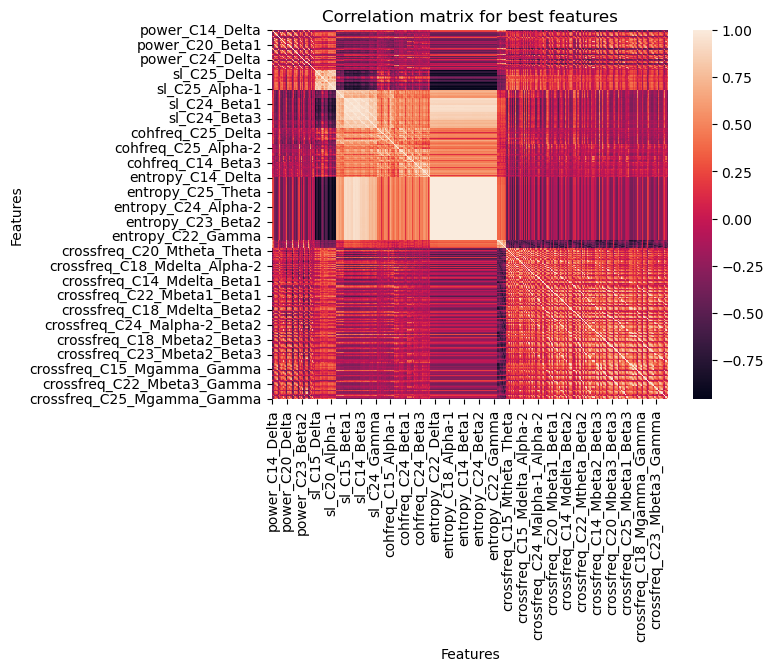

In [82]:
sns.heatmap(new_data.corr())
plt.title('Correlation matrix for best features')
plt.xlabel('Features')
plt.ylabel('Features')
plt.savefig(path_plot+'/'+'correlation_randomforest.png')

In [83]:
selected_best_features = [new_data.columns.get_loc(c) for c in best_features if c in new_data]
selected_best_features

[309,
 342,
 53,
 341,
 359,
 57,
 326,
 54,
 360,
 369,
 334,
 355,
 327,
 340,
 46,
 132,
 270,
 308,
 56,
 174,
 139,
 375,
 202,
 283,
 302,
 204,
 175,
 370,
 111,
 288,
 333,
 189,
 208,
 332,
 210,
 307,
 199,
 206,
 147,
 66,
 166,
 47,
 220,
 361,
 68,
 185,
 184,
 62,
 203,
 198,
 212,
 127,
 200,
 125,
 322,
 358,
 167,
 180,
 325,
 177,
 133,
 186,
 19,
 191,
 187,
 368,
 354,
 353,
 188,
 295,
 213,
 140,
 67,
 168,
 207,
 218,
 197,
 61,
 211,
 30,
 55,
 292,
 183,
 178,
 58,
 171,
 350,
 257,
 73,
 176,
 201,
 209,
 65,
 205,
 0,
 321,
 301,
 102,
 63,
 76,
 173,
 179,
 181,
 71,
 15,
 305,
 169,
 16,
 195,
 194,
 172,
 315,
 4,
 339,
 320,
 182,
 196,
 64,
 83,
 349,
 141,
 190,
 49,
 193,
 134,
 276,
 157,
 74,
 89,
 170,
 104,
 27,
 11,
 146,
 144,
 214,
 159,
 345,
 109,
 330,
 21,
 103,
 59,
 282,
 126,
 275,
 352,
 338,
 60,
 162,
 14,
 266,
 154,
 192,
 79,
 164,
 149,
 69,
 105,
 316,
 1,
 115,
 298,
 82,
 110,
 81,
 156,
 148,
 235,
 93,
 367,
 138,
 48,
 123,
 

In [84]:
best_features

['crossfreq_C14_Mbeta3_Beta3',
 'crossfreq_C14_Mgamma_Gamma',
 'sl_C14_Alpha-1',
 'crossfreq_C14_Mbeta3_Gamma',
 'crossfreq_C22_Mbeta2_Gamma',
 'sl_C22_Alpha-1',
 'crossfreq_C22_Mbeta2_Beta3',
 'sl_C15_Alpha-1',
 'crossfreq_C22_Mbeta3_Gamma',
 'crossfreq_C24_Mbeta3_Gamma',
 'crossfreq_C24_Mbeta3_Beta3',
 'crossfreq_C20_Mgamma_Gamma',
 'crossfreq_C22_Mbeta3_Beta3',
 'crossfreq_C14_Mbeta2_Gamma',
 'sl_C14_Theta',
 'cohfreq_C23_Beta2',
 'crossfreq_C22_Mbeta1_Beta1',
 'crossfreq_C14_Mbeta2_Beta3',
 'sl_C20_Alpha-1',
 'entropy_C14_Alpha-2',
 'cohfreq_C23_Beta3',
 'crossfreq_C25_Mgamma_Gamma',
 'entropy_C22_Beta3',
 'crossfreq_C14_Mbeta2_Beta2',
 'crossfreq_C24_Mbeta2_Beta2',
 'entropy_C24_Beta3',
 'entropy_C15_Alpha-2',
 'crossfreq_C24_Mgamma_Gamma',
 'cohfreq_C25_Theta',
 'crossfreq_C18_Mbeta2_Beta2',
 'crossfreq_C24_Mbeta2_Beta3',
 'entropy_C25_Beta1',
 'entropy_C18_Gamma',
 'crossfreq_C24_Mbeta1_Beta3',
 'entropy_C22_Gamma',
 'crossfreq_C14_Mbeta1_Beta3',
 'entropy_C15_Beta3',
 'entropy_

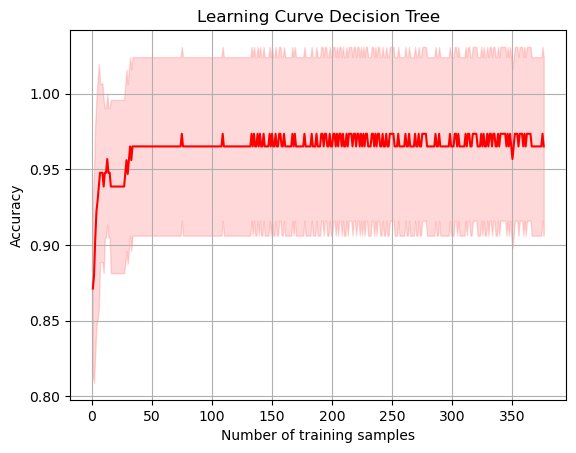

In [85]:
acc = []
std = []
m=[]
for index, feature_name in enumerate(best_features,start=1):

    input_features_best = best_features[:index]
    input_best_index = [data.columns.get_loc(c) for c 
                      in input_features_best if c in data]
    fbest_model = best_selected.fit(X_train[:, input_best_index], y_train)
    scores_best = cross_val_score(
                        estimator=fbest_model,
                        X=X_train[:, input_best_index],
                        y=y_train,
                        cv=10,
                        n_jobs=-1
                        )
    
  
    #m['number_features_BEST' + str(index)] = fbest_model
    acc.append(np.mean(scores_best))
    std.append(np.std(scores_best))

plt.plot(
        range(1, len(acc)+1),
        acc,
        color='red'
        ) 
plt.title('Learning Curve Decision Tree')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')

plt.fill_between(
                range(1, len(acc)+1),
                np.array(acc) + np.array(std),
                np.array(acc) - np.array(std),
                alpha=0.15,
                color='red'
                )

plt.grid()
plt.savefig(path_plot+'/'+'features_plot_best.png')
plt.show()

In [86]:
print(acc[-1])
print(std[-1])

0.9651515151515152
0.05899370404221753


In [87]:
predicted = fbest_model.predict(X_test[:,input_best_index])
classes_x=(predicted >= 0.5).astype(int)
computerprecision(y_test,classes_x)

Precision:  1.0 
 Recall:  1.0 
 F1-score: 1.0


Confusion matrix, without normalization
[[20  0]
 [ 0 10]]


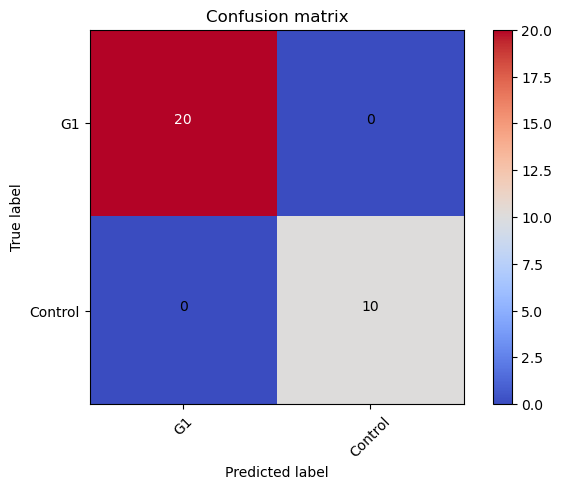

In [88]:
class_names=['G1','Control']
cm_test = confusion_matrix(y_test,classes_x)
plot_confusion_matrix(path_plot,cm_test,classes=class_names,title='Confusion matrix')

In [105]:
train_sizes, train_scores, test_scores = \
    learning_curve(
                  estimator=modelos[best_model],
                  X=X_test[selected_best_features],## Revisar
                  y=y_train[selected_best_features],
                  train_sizes=np.linspace(0.1, 1, 10),
                  cv=10,
                  n_jobs=-1
                  )
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)# test_score
test_std = np.std(test_scores, axis=1)

plt.plot(
        train_sizes,
        train_mean,
        color='blue',
        marker='o',
        markersize=5,
        label='training accuracy'
        )

plt.fill_between(
                train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15,
                color='blue'
                )

plt.plot(
        train_sizes,
        test_mean,
        color='green',
        linestyle='--',
        marker='s',
        markersize=5,
        label='validation accuracy'
        )

plt.fill_between(
                train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15,
                color='green'
                )

plt.grid()
plt.title('Validation curve for best model (Decision Tree)')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.0])
plt.savefig(path_plot+'/'+'validation_best model.png')
plt.show()

IndexError: index 309 is out of bounds for axis 0 with size 30

### SVM (Grid Search)

In [ ]:
svm_param_grid = {'C': list(np.logspace(-1, 4, 6)), 
                 'gamma': list(np.logspace(-3, 2, 6)) + ['Auto'] + ['scale'],
                 'kernel': ['rbf', 'poly']} 

svc = SVC()
svc_clf = GridSearchCV(
                      svc,
                      svm_param_grid,
                      n_jobs=-1,
                      cv=10
                      )

svm_best_clf = svc_clf.fit(X_train, y_train)
best_model = svm_best_clf.best_estimator_

c:\Users\veroh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\veroh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\veroh\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 180, in fit
    self._validate_params()
  File "c:\Users\veroh\anaconda3\lib\site-packages\sklearn\base.py", line 581, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\veroh\anaconda3\lib\site-packages\sk

In [ ]:
best_model.fit(X_train, y_train)

SVC(C=0.1, gamma=0.001)

In [ ]:
predicted = best_model.predict(X_test)

In [ ]:
print(
    f"Classification report for classifier {best_model}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
    )

Classification report for classifier SVC(C=0.1, gamma=0.001):
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80        20
         1.0       0.00      0.00      0.00        10

    accuracy                           0.67        30
   macro avg       0.33      0.50      0.40        30
weighted avg       0.44      0.67      0.53        30




c:\Users\veroh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\veroh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\veroh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
dataframe_metrics = metrics.classification_report(y_test, predicted, output_dict=True)
dataframe_metrics = pd.DataFrame(dataframe_metrics).T
dfi.export(dataframe_metrics, path_plot+'/'+'metrics_SVM.png')

c:\Users\veroh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\veroh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\veroh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Program Files\Google\Chrome\Application\chrome.exe


### SVM (Permutation importance)

In [ ]:
# results = permutation_importance(
#                                 best_model,
#                                 X_train,
#                                 y_train,
#                                 scoring='accuracy'
#                                 )

# nombres_columnas = data.columns[:-1]
# importance = results.importances_mean
# index = np.argsort(importance)

# for v, idx in zip(importance, index):
    
#     print(f'Feature: {nombres_columnas[idx]} | Score: {v}')


### SVM con caracteristicas seleccionadas del árbol de decisión

In [94]:
acc_per_feature_svm = []
std_per_feature_svm = []

for index, feature_name in enumerate(sorted_names,start=1):

    input_features_names = sorted_names[:index]
    input_features_index = [data.columns.get_loc(c) for c 
                      in input_features_names if c in data]
    best_model.fit(X_train[:, input_features_index], y_train)
    scores = cross_val_score(
                        estimator=best_model,
                        X=X_train[:, input_features_index],
                        y=y_train,
                        cv=10,
                        n_jobs=-1
                        )
    acc_per_feature_svm.append(np.mean(scores))
    std_per_feature_svm.append(np.std(scores))

plt.plot(
        range(0, len(sorted_names)),
        acc_per_feature_svm,
        color='red'
        ) 
plt.title('Learning Curve SVM')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.fill_between(
                range(0, len(sorted_names)),
                np.array(acc_per_feature_svm) + np.array(std_per_feature_svm),
                np.array(acc_per_feature_svm) - np.array(std_per_feature_svm),
                alpha=0.15,
                color='red'
                )

plt.grid()

AttributeError: 'str' object has no attribute 'fit'

### TPOT

In [90]:
pipeline_optimizer = TPOTClassifier()

In [91]:
pipeline_optimizer = TPOTClassifier(
                                    generations=5,
                                    population_size=int(X.shape[0]*0.4),
                                    cv=10,
                                    random_state=10,
                                    verbosity=3,
                                    n_jobs=-1
                                    )

In [92]:
pipeline_optimizer.fit(X_train, y_train)

32 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/348 [00:00<?, ?pipeline/s]

Skipped pipeline #18 due to time out. Continuing to the next pipeline.
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True.
_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required by MLPClassifier..
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty..
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 1 - Current Pareto front scores:

-1	0.9742424242424242	ExtraTreesClassifier(input_matrix, ExtraTreesClassifier__bootstrap=True, ExtraTreesClassifier__criterion=entropy, ExtraTreesClassifier__max_features=0.7500000000000001, ExtraTreesClassifier__min_sample

TPOTClassifier(cv=10, generations=5, n_jobs=-1, population_size=58,
               random_state=10, verbosity=3)

In [93]:
print(pipeline_optimizer.score(X_test, y_test))

0.9666666666666667


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py:794: FutureWarning: sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.
  warnings.warn(
